In [1]:
import os, sys
import pathlib
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import models, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


In [2]:
# Data loading
seed = 69
AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(seed)
np.random.seed(seed)

data_dir = pathlib.Path('s1_release')
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', labels)

# load given train set
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/labels[0]))))
print('Example file tensor:', filenames[0])

train_files = filenames[:round(num_samples*0.8)]  # first 80%
val_files = filenames[round(num_samples*0.8):]  # last 20%

print('Training set size', len(train_files))
print('Validation set size', len(val_files))

# load given test set
data_dir = pathlib.Path('s1_test_release')
test_files = tf.io.gfile.glob(str(data_dir) + '/*')  # provided
print('Test set size', len(test_files))

Commands: ['bird' 'eight' 'falcon' 'five' 'four' 'nine' 'one' 'seven' 'six' 'snake'
 'three' 'two' 'zero']
Number of total examples: 2600
Number of examples per label: 200
Example file tensor: tf.Tensor(b's1_release\\eight\\train_eight_3345.wav', shape=(), dtype=string)
Training set size 2080
Validation set size 520
Test set size 649


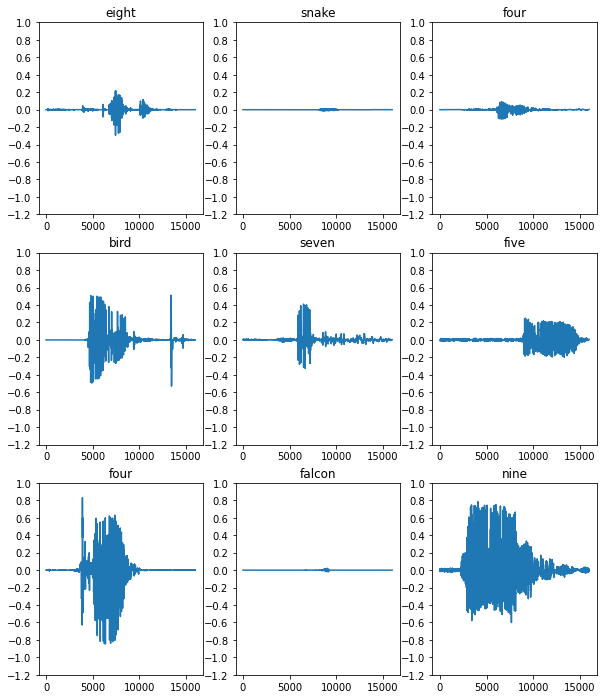

Label: eight
Waveform shape: (16000,)
Spectrogram shape (make this square): (517, 513)
Audio playback


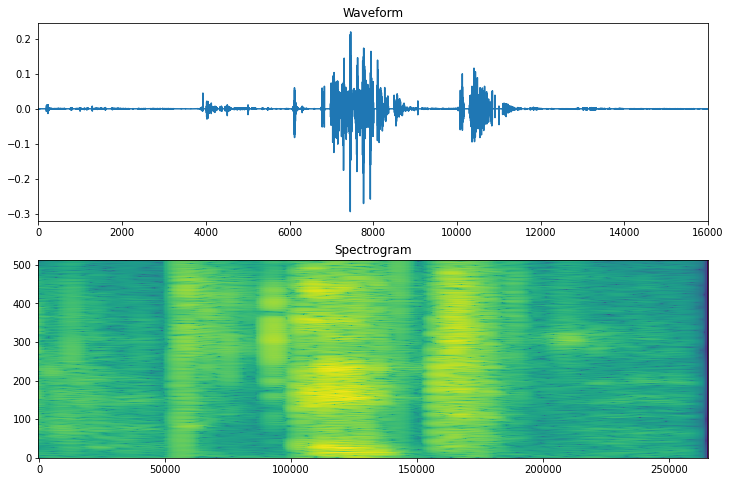

In [11]:
def get_waveform_and_label(file_path):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    waveform = tf.squeeze(audio, axis=-1)
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    return waveform, label

train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

def plot_multiple_waveform(ds):
    rows = 3
    cols = 3
    n = rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
    for i, (audio, label) in enumerate(ds.take(n)):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      ax.plot(audio.numpy())
      ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
      label = label.numpy().decode('utf-8')
      ax.set_title(label)
    plt.show()

plot_multiple_waveform(train_ds)

def plot_multiple_spectrogram(ds):
    rows = 3
    cols = 3
    n = rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, (spectrogram, label_id) in enumerate(ds.take(n)):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
      ax.set_title(labels[label_id.numpy()])
      ax.axis('off')
    plt.show()

def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square.
    spectrogram = tf.signal.stft(equal_length, frame_length=1001, frame_step=31, pad_end=True)  # 257, 70 -> 225, 257 || 255, 123 -> 129, 129
    spectrogram = tf.abs(spectrogram)
    return spectrogram

for waveform, label in train_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape (make this square):', spectrogram.shape)
    img_height, img_width = spectrogram.shape
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

def plot_spectrogram(spectrogram, ax):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec, shading='auto')

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  spectrogram = tf.image.grayscale_to_rgb(spectrogram)  # RGB if using pretrained network that is trained on RGB images e.g. ImageNet, else can gray scale
  label_id = tf.argmax(label == labels)
  return spectrogram, label_id

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = train_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
val_ds = preprocess_dataset(val_files)
# plot_multiple_spectrogram(train_ds)

In [4]:
# Training
batch_size = 32
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

input_shape = (img_height, img_width, 3)
print('Input shape:', input_shape)
num_labels = len(labels)
norm_layer = Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

# Resnet 50 pretrained
xInput = Input([img_height, img_width, 3], dtype=tf.uint8)
x = Resizing(224, 224)(xInput)
x = norm_layer(x)
x = tf.cast(x, tf.float32)
# x = keras.applications.resnet.preprocess_input(x)
resnet50 = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet50.trainable = True
x = resnet50(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
xOutput = Dense(num_labels)(x)  # no activation as loss using logit=True
model = tf.keras.models.Model(xInput, xOutput)

# xInput = Input(input_shape)
# x = Resizing(64, 64)(xInput)
# x = norm_layer(x)
# x = Conv2D(64, 3)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
# x = Conv2D(128, 3)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
# x = Conv2D(256, 3)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
# x = MaxPooling2D()(x)
# x = Dropout(0.5)(x)
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# xOutput = Dense(num_labels)(x)  # no activation as using logits for loss
# model = Model(xInput, xOutput)

Input shape: (517, 513, 3)


In [5]:
# model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# module = hub.KerasLayer(model_url)
#
# class MyBiTModel(tf.keras.Model):
#   def __init__(self, num_classes, module):
#     super().__init__()
#
#     self.num_classes = num_classes
#     self.head = Dense(num_classes, kernel_initializer='zeros')
#     self.bit_model = module
#
#   def call(self, images):
#     # No need to cut head off since we are using feature extractor model
#     bit_embedding = self.bit_model(images)
#     return self.head(bit_embedding)
#
# model = MyBiTModel(num_classes=num_labels, module=module)

In [6]:
opt = keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-6)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
epoch = 100
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, verbose=1)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='SC1.png')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 517, 513, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0     

In [7]:
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)
model.save('sc1')

Epoch 1/100
65/65 [==============================] - 25s 285ms/step - loss: 2.7201 - accuracy: 0.0981 - val_loss: 2.5687 - val_accuracy: 0.0846

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: sc1\assets


In [8]:
# Generate prediction csv
# model = models.load_model('sc1')
to_predict_ds = preprocess_dataset(list(map(str, test_files)))
i = 0
predicted_labels, filenames = [], []
for spectrogram, label in to_predict_ds.batch(1):
    # print(files_to_predict[i])
    # display.display(display.Audio(files_to_predict[i]))
    filenames.append(os.path.basename(test_files[i]))
    prediction = model(spectrogram)
    prediction_value = tf.nn.softmax(prediction[0]).numpy()
    predicted_label = labels[np.argmax(prediction_value)]
    predicted_labels.append(predicted_label)
    # plt.bar(labels, prediction_value)  # need to softmax raw prediction because model does not include softmax
    # plt.title(f'Confidence for each class')
    # plt.show()
    # print(f'True label: {labels[label[0]]}, Predicted label: {labels[np.argmax(prediction_value)]}, confidence level: {round(np.amax(prediction_value) * 100, 5)}%\n')
    i+=1

df = pd.DataFrame(list(zip(filenames, predicted_labels)))
df.to_csv('challenge_2_team_Tensor is not flowing.csv', index=False, header=False)  # tested submission file format passed

In [9]:
'''
ResNet 50 Full train with norm layer image net weight final val: 8115
spectrogram = tf.signal.stft(equal_length, frame_length=1001, frame_step=31, pad_end=True)  # 257, 70 -> 225, 257 || 255, 123 -> 129, 129

ResNet 152 V2 Full train with norm layer final val: 7615
BiT m-r101x1 final val: 6019
'''

'\nResNet 50 Full train with norm layer final val: 7923\nspectrogram = tf.signal.stft(equal_length, frame_length=1000, frame_step=31, pad_end=True)\n\nResNet 152 V2 Full train with norm layer final val: 7615\nBiT m-r101x1 final val: 6019\n'